In [ ]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 137.51 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
import csv

DATA_FILE = '/content/tda_ai_text_generation/research-abstracts-labeled-first-100.csv'

human_texts = []
ai_texts = []
with open(DATA_FILE) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None) # Skip header row
    for row in csv_reader:
      if row[1] == '0':
        human_texts.append(row[2])
      else:
        ai_texts.append(row[2])
# Print first 2 rows to sanity check
ai_texts[:2]

['In this study, we investigate the coupling loss on bi-columnar BSCCO/Ag tapes using a.c. susceptibility measurements. The bi-columnar structure of BSCCO tapes is known to offer several advantages over traditional tape configurations, including increased tolerance to magnetic field disturbances. However, the effects of the Bi-2212/Ag interface on the coupling between the superconducting filaments of the BSCCO tape is not well understood. Our experiments show that the coupling loss is dominated by the Bi-2212/Ag interface and varies significantly with the orientation and magnitude of the applied a.c. magnetic field. Specifically, coupling loss is found to be lower for in-plane magnetic fields and higher for out-of-plane magnetic fields. We also observe that the annealing of the tapes significantly affects the coupling loss, as annealed tapes exhibit lower loss values than unannealed tapes. Furthermore, we find that the coupling loss is sensitive to the orientation of the Ag matrix, as 

In [ ]:
!pip install nltk

In [ ]:
import string
import nltk
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import torch

# ENCODING_TYPE = 'bow'
ENCODING_TYPE = 'sentence-bert'

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

wnl = WordNetLemmatizer()

text = ai_texts[0]

sentences = sent_tokenize(text)
tokens = sentences

if ENCODING_TYPE == 'bow':
  proceesed_sentences = []
  for sentence in sentences:
    # Uncomment to remve punctuation if not doing sentence-level transform
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    filtered_text = []

    for word in word_tokenize(sentence):
      filtered_text.append(wnl.lemmatize(word, pos="v").lower())

    post_filtered_text = ' '.join(filtered_text)
    proceesed_sentences.append(post_filtered_text)
  vectorizer = CountVectorizer()
  embeddings = vectorizer.fit_transform(proceesed_sentences)


elif ENCODING_TYPE == 'sentence-bert':
  embeddings = bert_model.encode(sentences)



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
# This section generates and reformats the cosine similarity distances between
# each pair of points and generates an array of all possible threshold values
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import numpy as np

n_dpts = len(sentences) # Number of data points
cosSimDistances = np.zeros((n_dpts, n_dpts)) # preallocate pairwise distance matrix

# Label each sentence starting at 0, 1, 2, ...
# Track distance between sentence i and sentence j in (i,j) entry of matrix
# Matrix will be upper triangular
for pair1_i, pair2_i in itertools.combinations(range(len(sentences)), 2):
  cos_sim = cosine_similarity(embeddings[pair1_i].reshape(1, -1), embeddings[pair2_i].reshape(1, -1))[0][0]
  dist = 2 * np.arccos(cos_sim) / np.pi
  cosSimDistances[pair1_i][pair2_i] = dist
# make distances matrix symmetric (fill in below diagonal) to align with scikit
# pairwise metric matrix output that goes into Ripser.
cosSimDistances= cosSimDistances + cosSimDistances.T - np.diag(cosSimDistances.diagonal())
print(cosSimDistances)
thresholds = np.sort(np.unique(cosSimDistances))
print(thresholds)

[[0.         0.91309738 0.94451916 0.86106759 0.90778977 0.7836531
  0.82931783 0.93491193 0.73227953]
 [0.91309738 0.         0.90920734 0.92479887 0.84852198 0.91309738
  0.96555875 1.         0.92911811]
 [0.94451916 0.90920734 0.         0.85478287 0.95196742 0.96303881
  0.9559289  1.         0.95471923]
 [0.86106759 0.92479887 0.85478287 0.         0.75528541 0.8767133
  0.85263693 1.         0.92479887]
 [0.90778977 0.84852198 0.95196742 0.75528541 0.         0.8767133
  0.88991424 1.         0.92479887]
 [0.7836531  0.91309738 0.96303881 0.8767133  0.8767133  0.
  0.82931783 1.         0.82452034]
 [0.82931783 0.96555875 0.9559289  0.85263693 0.88991424 0.82931783
  0.         1.         0.89626823]
 [0.93491193 1.         1.         1.         1.         1.
  1.         0.         1.        ]
 [0.73227953 0.92911811 0.95471923 0.92479887 0.92479887 0.82452034
  0.89626823 1.         0.        ]]
[0.         0.73227953 0.75528541 0.7836531  0.82452034 0.82931783
 0.84852198 0.8

In [60]:
# set up Ripser for use (run this just once)
!pip install Ripser

from ripser import ripser
from persim import plot_diagrams

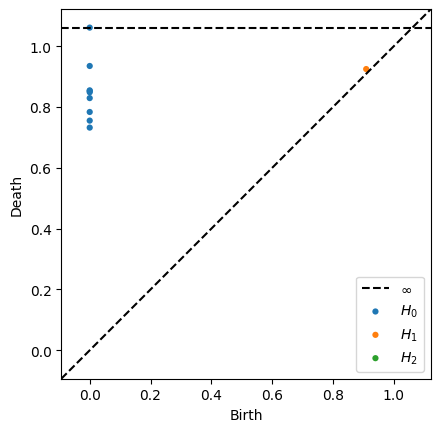

[[0.         0.73227954]
 [0.         0.75528544]
 [0.         0.78365308]
 [0.         0.82931781]
 [0.         0.84852195]
 [0.         0.85263693]
 [0.         0.85478288]
 [0.         0.93491191]
 [0.                inf]]


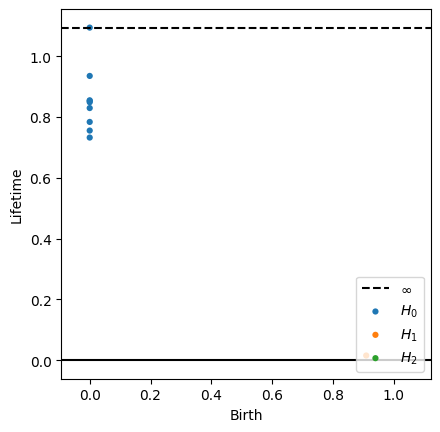

In [61]:
# Here's one way to use Ripser
# examples and instructions are here:
# https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
# https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix


# This version uses the distance matrix input, which is what we want
diagrams = ripser(cosSimDistances, distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams, show=True)
plot_diagrams(diagrams, lifetime=True)

# This is an example that uses the data directly and uses the euclidean metric
#data = np.random.random((100,3))
#diagrams = ripser(data, maxdim=2)['dgms']
#plot_diagrams(diagrams, show=True)
#plot_diagrams(diagrams, lifetime=True)

# it appears that diagrams is a vector of vectors where each element of each
# vector is [birth epoch, death epoch] and the vectors are in increasing order
# of homology (H0, H1, H2, etc.). For example, here is the H0 vector:
print(diagrams[0])
# Interpreting what each homology means is a different problem

In [ ]:
## Helper functions NOT based on publication

# to find all the unique lists in a large list of lists
def union_lists(lists):
  # Convert each list to a tuple and package as a set
  # (which automatically is unique)
  unique_tuples = {tuple(a_list) for a_list in lists}
  # Convert the tuples back to lists
  unique_arrays = [list(tup) for tup in unique_tuples]
  return unique_arrays

# to find all the lists in list A that are not in list B
def diff_lists(A, B):
  # Convert each list in the master list to a tuple and package everything as
  # a set. Then do set difference using minus operator
  diff_tuples = list({tuple(a_list) for a_list in A} - {tuple(b_list) for b_list in B})
  # Convert the tuples back to lists
  diff_list = [list(tup) for tup in diff_tuples]
  return diff_list

# to find all the lists in list A that are in list B
def intersect_lists(A, B):
  # Convert each list in the master list to a tuple and package everything as
  # a set. Then do set intersection using & operator
  intersect_set = {tuple(a_list) for a_list in A} & {tuple(a_list) for a_list in B}
  # Convert the tuples back to lists
  intersection_list = [list(tup) for tup in intersect_set]
  return intersection_list

# allSimplices should have same length as the height of newBoundMat
# L should be the # of items in newSimplices and the width of newBoundMat
def findNewItemsBoundary(allSimplices, newSimplices, newBoundMat, L_all, L_new):
  # iterate over each list item in newSimplices
  for i in range(L_new):
    # get length which defines the type of simplex
    n = len(newSimplices[i])
    # no need to find the boundary for a 0-simplex, so find boundary for n > 1
    if n > 1: # ignore
      for j in range(n):
        # create a boundary simplex by ejection
        tmp = newSimplices[i][:n-1-j] + newSimplices[i][n-j:]
        # search allSimplices for a match and insert a 1 in the boundary matrix
        newBoundMat[allSimplices.index(tmp), i] = 1
  return newBoundMat

# return column index of first column in the boundary matrix to conflict
# with the specified column. Conflict means the lowest ones for the two
# columns are in the same row.
def findFirstConflictColumn(boundMat, bCol):
  # find lowest one in the specified boundary matrix row
  # if no one exists, set to -1
  lowOneRow = max(np.nonzero(boundMat[:, bCol])[0], default=-1)
  # set the match column to an error-checkable value
  matchColumn = -1
  # proceed to find matches
  if lowOneRow >= 0: # only attempt to match if there is a lowest one
    # for each column before the one being checked
    for testCol in range(bCol):
      # if it is a 1
      if boundMat[lowOneRow, testCol]:
        # and if it is the lowest 1 in that column
        if max(np.nonzero(boundMat[:, testCol])[0], default=-1) == lowOneRow:
          # then it is a conflict/match to be resolved
          matchColumn = testCol
          break
  return [matchColumn, lowOneRow]

In [ ]:
## Helper functions based on publication
# The functions in this section are tailored implementations of algorithms
# found in the following paper:

# Zomorodian, A. (2010). Fast construction of the Vietoris-Rips complex.
# Computers & Graphics, 34(3), 263–271.
# https://doi.org/https://doi.org/10.1016/j.cag.2010.03.007

# refer to: Article Section 4.2
# inputs: both C0 and C1 from complex K, max dimension (3 = tetrahedra)
def RipsComplex(K_C0, K_C1, k):
  nu = [] # this will be expanded to hold all the simplices of all sizes
  for i in range(len(K_C0)): # for each vertex in C0
    # find the other, lower ordered vertices that have an edge connecting them
    # to this vertex
    N = LowerPairVertices(K_C0, K_C1, i)
    # build all the cofaces
    nu = AddCofaces(K_C0, K_C1, k, K_C0[i], N, nu)
  return nu

# refer to: Article Section 4.2
# inputs: complex K (C0 and C1), max dimension (3 = tetrahedra), set
# containing a vertex, set containing lower points paired with that vector,
# and current built-up V-R complex
def AddCofaces(K_C0, K_C1, k, tau, N, nu):
  nu = union_lists(nu + [tau])
  if len(tau) < k+1:  # if dim(tau) >= k (has k+1 or more points)
    for i in range(len(N)):
      sigma = N[i] + tau # element to be added to nu
      M = LowerPairVertices(K_C0, K_C1, N[i][0])
      M = intersect_lists(N, M) # intersection means triangle
      nu = AddCofaces(K_C0, K_C1, k, sigma, M, nu)
  return nu

# refer to: Article Section 4.1
# inputs: both C0 and C1 of complex K, index of the vertex for which to find
# lower ordered points that are paired by an edge.
def LowerPairVertices(K_C0, K_C1, i_u):
  # get indices i_N of lower vertices paired with vertex u, which has index i_u
  i_N = np.nonzero(K_C1[0:i_u,i_u])[0]
  # get the set N of lower vertices v paired with vertex u
  N = list(K_C0[i] for i in i_N)
  return N

In [ ]:
## To wrap the array outputs while we error-check NU
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
## Generate simplicial complexes

from scipy.special import comb # for comb() (i.e. "nChooseK")

# set max dimension to compute
K_C0 = []
for i in range(n_dpts):
  K_C0.append([i])

# set max dimension to compute
dims = 3 # 0 - points, 1 - edges, 2 - triangles, 3 - tetrahedra, etc.
# compute the total number of things that will be in the complex at the max
# threshold, based on the selected # of dimensions
totalSizeNu = n_dpts # the points will always be in the complex

# compute the total # of simplices that will exist at the max threshold
for i in range(dims):
  # add # of ith dimension entries in the complex at max threshold
  totalSizeNu = totalSizeNu + comb(n_dpts, i+2, exact=True)

# preallocate big boundary matrix and an array to track the index of the
# simplex in the full complex (and row in the boundary matrix)
# corresponding to each column in the boundary matrix. Assume the boundary
# matrix will have half as many columns as the number of simplices due to
# removal of zero columns during each iteration
boundaryMatrix = np.zeros((totalSizeNu, round(totalSizeNu/2)), dtype=bool)
nuColIndexFromBoundColIndex = np.zeros(round(totalSizeNu/2), dtype=np.int32)
w_bd = 0 # zero boundary matrix columns originally filled in
# preallocate last iteration complex and reset to correct data type
nu_prev = [[]] * totalSizeNu
# track number of actual items set in nu_prev
L_prev = 0
# preallocate epoch and dimension trackers to -1 for error checking later
# birthEpoch = -1*ones(1,totalSizeNu,'int16')
birthEpoch = -1*np.ones(totalSizeNu, dtype=np.int16)
deathEpoch = -1*np.ones(totalSizeNu, dtype=np.int16)
dimension = -1*np.ones(totalSizeNu, dtype=np.int8)
# preallocate full complex buildup and reset to correct data type
epochOrderedComplex = [[]] * totalSizeNu

# iterate through each threshold value, building up birthEpoch, deathEpoch,
# and dimension arrays corresponding to the epochOrderedComplex and
# allHomologies arrays. The reduced boundary matrix will also be an
# output at each iteration
for epoch in range(len(thresholds)):
  print('===================================================================')
  print('EPOCH =',epoch)
  # first determine which edges are in the complex based on threshold
  K_C1 = cosSimDistances <= thresholds[epoch] # logical array of "in" edges
  print('K_C1 =')
  print(K_C1)
  # compute the complex as a huge array of dot-delimited strings
  nu = RipsComplex(K_C0, K_C1, dims)
  print('nu =', nu)
  # find new complex items for this epoch
  newInComplex = diff_lists(nu, nu_prev)
  L_new = len(newInComplex)
  L_tot = L_prev + L_new
  # order newInComplex by simplex size so that each simplex can possibly be
  # destroyed by something to its right in its own birth epoch if needed
  newInComplex = sorted(newInComplex, key=len)
  # update tracking of epoch number for new complex items
  birthEpoch[L_prev:L_tot] = epoch
  # add new items to the ordered list of items. These are used for
  # columns and rows in the big boundary matrix and for naming in the
  # persistence diagrams
  epochOrderedComplex[L_prev:L_tot] = newInComplex

  # preallocate temp array to convert to boundary matrix using newItems
  temp = np.zeros((L_tot,L_new), dtype=bool)
  # fill temp in as boundary matrix of newInComplex
  temp = findNewItemsBoundary(epochOrderedComplex, newInComplex, temp, \
                              L_tot, L_new)
  # for each element in newInComplex
  for newCol in range(L_new):
    # put its boundary (column in temp) into next open col of boundary matrix
    boundaryMatrix[0:L_tot, w_bd] = temp[:,newCol]
    # find the first column with the same lowest 1, if such exists
    [matchCol, lowOneRow] = findFirstConflictColumn(boundaryMatrix,\
                                                    w_bd)
    # if no such column exists,
    while matchCol >= 0:
      # XOR the conflicting/matching column to the check column
      boundaryMatrix[0:L_tot, w_bd] = (boundaryMatrix[0:L_tot, w_bd] ^\
                                       boundaryMatrix[0:L_tot, matchCol])
      # add the element name for the matching column as a linear comb.
      # DO THIS LATER, NOT AS IMPORTANT. THIS USES nuColIndexFromBoundColIndex
      # reset matchCol. Since the column has been modified, the match
      # column will be different or nonexistent
      [matchCol, lowOneRow] = findFirstConflictColumn(boundaryMatrix,\
                                                      w_bd)

    # check if reduction has not zeroed out the column
    if lowOneRow >= 0: # if the column isn't zero, lowOneRow is a pivot
      # set death epoch for the killed row
      deathEpoch[lowOneRow] = epoch
      # add the index map to the index tracker
      nuColIndexFromBoundColIndex[w_bd] = L_prev + newCol
      # add one to the filled width of the boundary matrix
      w_bd = w_bd+1

  # latest complex is previous complex for next iteration
  nu_prev = nu
  L_prev = len(nu_prev)

EPOCH = 0
K_C1 =
[[ True False False False False False False False False]
 [ True  True False False False False False False False]
 [ True  True  True False False False False False False]
 [ True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False]
 [ True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True False False]
 [ True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True]]
nu = [[6], [2], [5], [8], [4], [1], [7], [0], [3]]
EPOCH = 1
K_C1 =
[[ True False False False False False False False  True]
 [ True  True False False False False False False False]
 [ True  True  True False False False False False False]
 [ True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False]
 [ True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True False False]
 [

[ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6  7  7  7  7  8  9 10
 11 12 12 13 13 13 13 13 14 14 15 15 15 15 16 16 16 16 17 17 17 17 18 18
 19 19 19 19 19 19 19 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22
 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 30 30 31 31
 31 31 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34
 34 34 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[-1  5  8  2 10  3 29  1  9 -1 -1 -1  4 -1 -1  6 -1  7 -1  7 -1 -1 -1 -1
 13 12 -1 13 -1 -1 13 -1 14 -1 15 -1 15 -1 16 -1 16 -1 17 -1 17 -1 18 -1
 19 -1 19 19 -1 -1 -1 20 -1 20 -1 21 -1 21 21 21 -1 -1 -1 -1 -1 22 -1 22
 22 

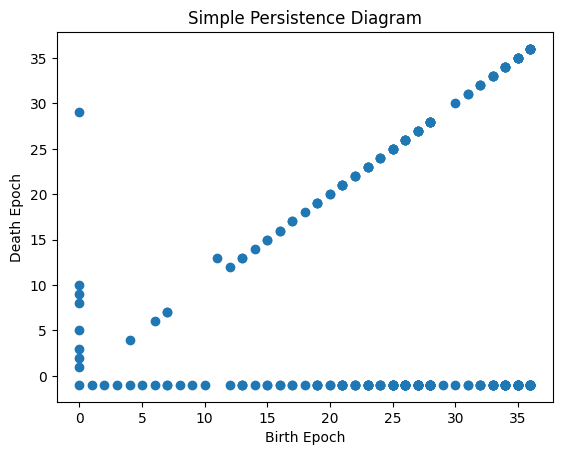

In [ ]:
# test plot of the birth and death data.
import matplotlib.pyplot as plt
print(birthEpoch)
print(deathEpoch)

# Create scatter plot
plt.scatter(birthEpoch, deathEpoch)

# Add title and labels
plt.title('Simple Persistence Diagram')
plt.xlabel('Birth Epoch')
plt.ylabel('Death Epoch')

# Show plot
plt.show()